# Green space and violence: 
### Using machine learning and deep learning to assess the relationship between local NDVI values and firearm assaults in Philadelphia
-----------------
#### MUSA 6950 Final Project by Jamie Song, MPH
#### Professor Xiaojiang Li - Spring 2025

## Introduction

Firearm violence is a persistent public health crisis in many U.S. cities, including Philadelphia, where it remains a leading cause of injury and death, particularly among younger people and Black men. Addressing this complex issue requires not only reimagining and rebuilding our criminal justice system, but also upstream strategies that consider the built and natural environments in which violence occurs.

Recent research suggests that urban greenness, such as tree cover, parks, and vegetated lots, may have a protective effect against violence by reducing stress, encouraging social cohesion, and discouraging illegal activity. However, much of the existing literature relies on coarse measures of greenness or aggregated spatial units (such as census tracts or block groups), which may obscure important localized variation. Furthermore, few studies leverage high-resolution remote sensing data or advanced AI models to explore these associations at scale.

This project investigates the spatial relationship between urban greenness and firearm assaults in Philadelphia by integrating high-resolution satellite imagery from the National Agriculture Imagery Program (NAIP) with geocoded point-level data on firearm incidents. The central research question is:

> **To what extent can urban green space, measured by NDVI from NAIP imagery, predict the spatial distribution of firearm injuries in Philadelphia?**

To answer this question, we employ a suite of machine learning models — Random Forest, XGBoost, and a Convolutional Neural Network (CNN) — to predict firearm assault locations based on environmental features. The models are evaluated on their predictive performance using metrics such as precision-recall curves and area under the curve (AUC), and their spatial predictions are visualized to assess geographic patterns of risk.

This notebook documents the complete workflow, from data preprocessing and modeling to evaluation and spatial interpretation. Ultimately, we highlight the potential of AI-assisted environmental analysis to inform violence prevention and urban sustainability efforts.


## Setup

First, we must install any necessary packages and import the libraries we will use throughout the notebook.

In [3]:
# install packages not in environment
!pip install xgboost


In [ ]:
import rasterio as rio
from rasterio.mask import mask
from rasterio.windows import Window
import rasterio.plot
from rasterio.plot import plotting_extent
from rasterio.features import geometry_mask
from rasterio.transform import Affine
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import mapping, Point
from shapely.ops import unary_union
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F


import random

# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [ ]:
# check working directory
pwd

'/Users/songj/Documents/GitHub/ai-urban-sustainability/final-project'

We must also download the NAIP file from the link provided by Professor Li for a class lab assignment, and place it in our working directory shown above: [LINK](https://utilitiesfiles.s3.us-east-1.amazonaws.com/penn-class/ai-urban-sustainability/data/naip-philly.tif)

## Data Processing

### NAIP to NDVI

Now, we will import our NAIP imagery and calculate NDVI values.

In [ ]:
with rio.open('naip_philly.tif') as src:
    red = src.read(2).astype('float32')  # red band
    nir = src.read(1).astype('float32')  # NIR band
    transform = src.transform
    crs = src.crs
    ndvi_shape = src.shape

# calculate NDVI
ndvi = (nir - red) / (nir + red + 1e-6)
ndvi = np.clip(ndvi, -1, 1)

In [ ]:
phl_boundary = gpd.read_file('phl_boundary.geojson').to_crs(crs)

boundary_mask = geometry_mask(
    [geom for geom in phl_boundary.geometry],
    transform=transform,
    invert=True,
    out_shape=ndvi_shape
)

# apply boundary mask (set outside Philly to NaN)
ndvi_masked = np.where(boundary_mask, ndvi, np.nan)


#### NDVI validation

We validate here that our NDVI values correspond to expected green space regions in Philadelphia. In the following plot, we see clusters of high NDVI values in areas with known parks and green spaces, such as Fairmount Park and the Schuylkill River Trail. Conversely, we observe low NDVI values in urbanized areas with little vegetation. This step confirms that our NDVI calculations are accurate and meaningful for our analysis.

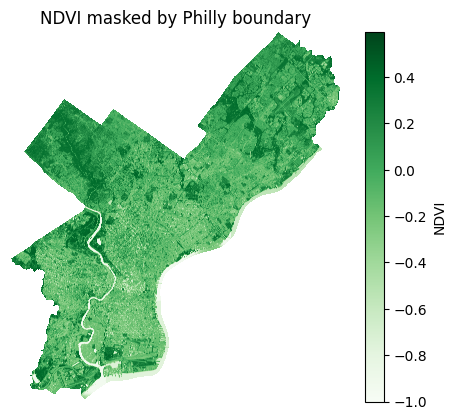

In [ ]:
# visualize the final masked NDVI
plt.imshow(ndvi_masked, cmap='Greens')
plt.title('NDVI masked by Philly boundary')
plt.colorbar(label='NDVI')
plt.axis('off')
plt.show()

### Generating firearm incident and control points

Here, we load our previously downloaded fatal and nonfatal firearm assault incidents from Nick Hand's Philadelphia gun violence data dashboard, which draws data from the Philadelphia Police Department. We use only 2016 data for this analysis, as the NAIP imagery is from 2016.

To generate the control points, we take the number of firearm incidents and generate the same number of random points across the city, being sure not to generate points in the water or outside of the city limits. We also ensure that the random points are not too close to each other, as this could lead to bias in our analysis.

In [ ]:
# prepare river mask
rivers_gdf = gpd.read_file('phl_rivers.geojson')
rivers_gdf = rivers_gdf.to_crs(crs)

# union of all river geometries
rivers_union = unary_union(rivers_gdf.geometry)

# difference: Philly boundary minus rivers
phl_minus_rivers = phl_boundary.geometry.iloc[0].difference(rivers_union)

In [ ]:
# read in gsw incident points
gsw16 = gpd.read_file('gsw2016.geojson')
gsw16 = gsw16.to_crs(crs)  # match NAIP CRS

# define function to extract NDVI patches
def extract_patch(ndvi, point, transform, patch_size=64):
    col, row = ~transform * (point.x, point.y)
    col, row = int(col), int(row)
    half = patch_size // 2
    patch = ndvi[row-half:row+half, col-half:col+half]
    return patch

# drop rows with empty geometries
gsw16 = gsw16[~(gsw16.geometry.is_empty | gsw16.geometry.isna())]

# loop through points and extract patches
patches = []
for idx, row in gsw16.iterrows():
    patch = extract_patch(ndvi_masked, row.geometry, transform)
    if patch.shape == (64, 64):
        patches.append(patch)


In [ ]:
def generate_control_points(polygon, num_points):
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(points) < num_points:
        pnt = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(pnt):
            points.append(pnt)
    return points

# generate same number of controls as incidents
num_controls = len(gsw16)
control_points = generate_control_points(phl_minus_rivers, num_controls)

# convert to gdf
control_gdf = gpd.GeoDataFrame(geometry=control_points, crs=crs)

In [ ]:
def calc_features(patch):
    flat = patch.flatten()
    flat = flat[~np.isnan(flat)]  # remove NaN values
    return {
        'mean_ndvi': np.mean(flat),
        'std_ndvi': np.std(flat),
        'min_ndvi': np.min(flat),
        'max_ndvi': np.max(flat),
        'pct_low_ndvi': np.sum(flat < -0.2) / len(flat)
    }

# apply to all patches
features = [calc_features(patch) for patch in patches]


In [ ]:
# combine incident and control points
incident_gdf = gsw16.copy()
incident_gdf['label'] = 1
control_gdf['label'] = 0

combined_gdf = pd.concat([incident_gdf, control_gdf])

# extract NDVI patches and compute features
patches = []
labels = []

for idx, row in combined_gdf.iterrows():
    patch = extract_patch(ndvi, row.geometry, transform)
    if patch.shape == (64, 64):
        features = calc_features(patch)
        patches.append(patch)
        labels.append(row['label'])
        features['label'] = row['label']


#### Processing for machine learning

In order to use our data in machine learning models, we need to process it into tabular data first. Therefore, we will calculate mean, standard deviation, minimum, and maximum NDVI values for each patch. We also calculate the percentage of the patch area that has NDVI values under -0.2 or "low NDVI".

In [ ]:
# calculate features for each patch
features = [calc_features(patch) for patch in patches]

# create df from feature dictionaries
features_df = pd.DataFrame(features)

# add labels, 1 = incident, 0 = control
features_df['label'] = labels

features_df.head()


,mean_ndvi,std_ndvi,min_ndvi,max_ndvi,pct_low_ndvi,label
0,-0.303733,0.301665,-0.948718,0.394636,0.638428,1
1,-0.184397,0.223338,-0.802198,0.431507,0.449707,1
2,-0.099057,0.259536,-0.857143,0.460208,0.297363,1
3,0.030316,0.268047,-0.769231,0.501945,0.139404,1
4,0.030316,0.268047,-0.769231,0.501945,0.139404,1


### Visualizing processed data

#### Mapping incident and control locations over NDVI

The following map shows the locations of firearm incidents and control points overlaid on the NDVI raster. The red points represent firearm incidents, while the blue points represent control points. This visualization allows us to see the spatial distribution of firearm incidents and control points in relation to urban greenness, and it also helps us validate the random point generation process. The control points are randomly distributed throughout the city, and we can see that they are not clustered in any particular area.

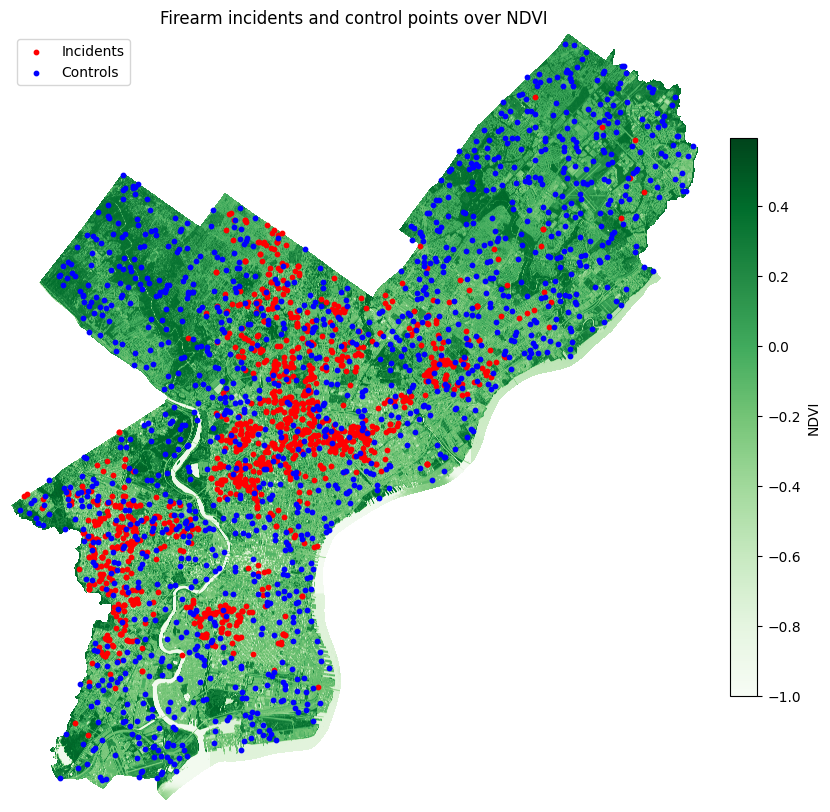

In [ ]:
# plot NDVI background
fig, ax = plt.subplots(figsize=(10, 10))
ndvi_plot = ax.imshow(ndvi_masked, cmap='Greens', extent=plotting_extent(src))

# add points
incident_scatter = ax.scatter(incident_gdf.geometry.x, incident_gdf.geometry.y, 
                              c='red', label='Incidents', s=10)
control_scatter = ax.scatter(control_gdf.geometry.x, control_gdf.geometry.y, 
                             c='blue', label='Controls', s=10)

# add legend and turn off axes
ax.legend()
ax.set_axis_off()

# add color bar for NDVI
cbar = plt.colorbar(ndvi_plot, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label('NDVI')

ax.set_title('Firearm incidents and control points over NDVI')

plt.show()



#### Visualizing NDVI patches

The following patches show the spatial distribution of NDVI values for five random patches selected from each patch type. Although n=5 is not a large enough sample size to draw any conclusions, we can already see that the NDVI values for the control patches are higher than those for the incident patches.

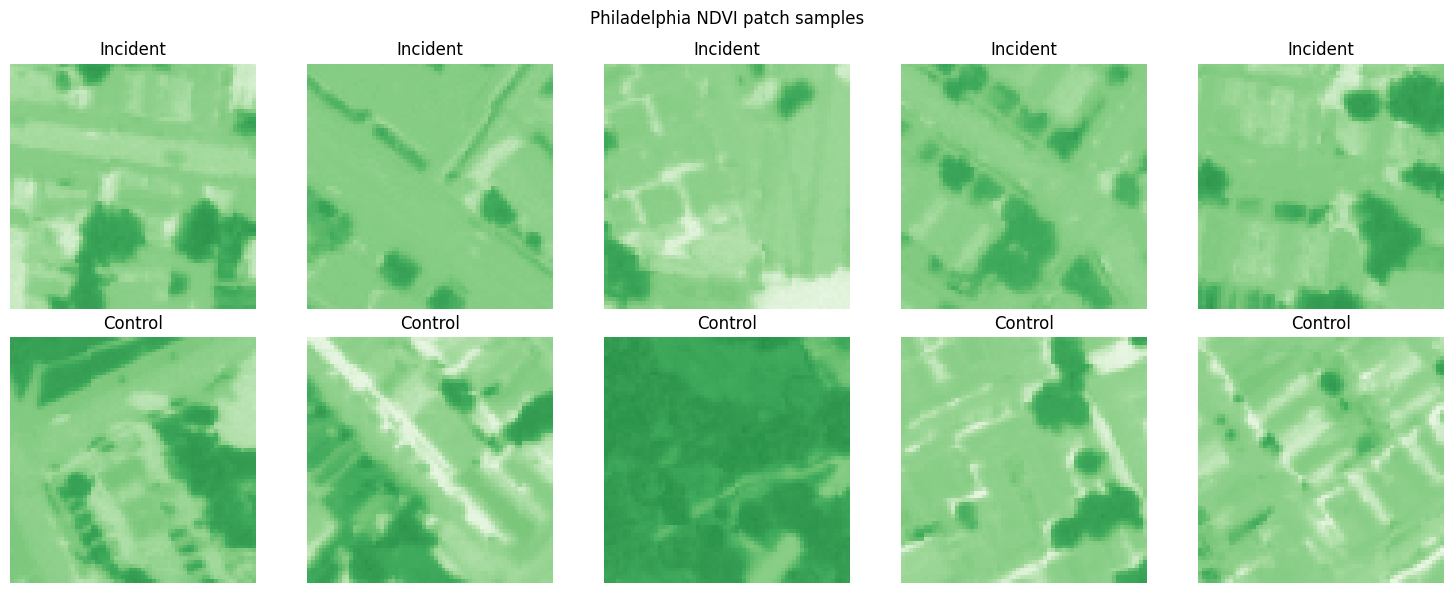

In [48]:
def show_random_patches(patches, labels, n=5):
    random.seed(42)
    fig, axes = plt.subplots(2, n, figsize=(15, 6))
    incident_indices = [i for i, l in enumerate(labels) if l == 1]
    control_indices = [i for i, l in enumerate(labels) if l == 0]

    random_incident_patches = random.sample(incident_indices, n)
    random_control_patches = random.sample(control_indices, n)

    for i in range(n):
        axes[0, i].imshow(patches[random_incident_patches[i]], cmap='Greens', vmin=-1, vmax=1)
        axes[0, i].set_title('Incident')
        axes[0, i].axis('off')

        axes[1, i].imshow(patches[random_control_patches[i]], cmap='Greens', vmin=-1, vmax=1)
        axes[1, i].set_title('Control')
        axes[1, i].axis('off')

    plt.suptitle('Philadelphia NDVI patch samples')
    plt.tight_layout()
    plt.show()

show_random_patches(patches, labels)


We also calculate that the patch size is 0.0441 square kilometers, which is approximately enough area to represent part of a city block or an entire street intersection. This patch size may need to be adjusted if this model is to be applied in a different urban area. 

In [ ]:
pixel_width = transform.a
pixel_height = -transform.e
patch_size = 64
area_m2 = patch_size * patch_size * pixel_width * pixel_height
area_km2 = area_m2 / 1e6
print(f"Patch area: {area_km2:.4f} km²")


Patch area: 0.0441 km²


#### Mean NDVI values by incident vs. control patches

Here, we confirm that control patches have higher mean NDVI values than incident patches. This may suggest that our machine learning models will be able to distinguish between the two patch types based on NDVI values alone.

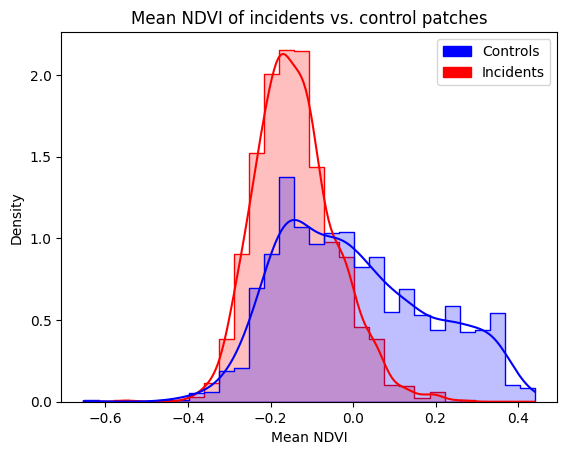

In [ ]:
# plot the histogram
sns.histplot(data=features_df, x='mean_ndvi', hue='label', bins=30, kde=True,
             palette={1: 'red', 0: 'blue'}, element='step', stat='density')

# manually define legend handles
incident_patch = mpatches.Patch(color='red', label='Incidents')
control_patch = mpatches.Patch(color='blue', label='Controls')

plt.legend(handles=[control_patch, incident_patch])
plt.title('Mean NDVI of incidents vs. control patches')
plt.xlabel('Mean NDVI')
plt.ylabel('Density')
plt.show()


## Machine Learning

Now, we will move on to conducting machine learning analyses. We will use two machine learning models for the sake of comparison and validating interpretability: Random Forest and XGBoost.

The task performed by these models is a binary classification problem: given a set of NDVI-derived features from a 64×64 meter patch, the model predicts whether the patch contains a firearm violence incident (label = 1) or a matched control location (label = 0). Each input to the model is a row in a tabular dataset representing a single patch with the aforementioned variables from our data processing section. These features are passed into the model, which learns to classify whether the greenness characteristics of a patch are associated with firearm violence or not. The output is a probability that the patch corresponds to an incident, which can be thresholded to make binary predictions.

First, we must split our data into training and testing sets. We will use 80% of the data for training and 20% for testing.

In [ ]:
# features and labels
X = features_df[['mean_ndvi', 'std_ndvi', 'min_ndvi', 'max_ndvi', 'pct_low_ndvi']]
y = features_df['label']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


### Random Forest

We will first use Random Forest, which is an ensemble learning method that builds multiple decision trees and averages their predictions to improve accuracy and reduce overfitting. Each tree is trained on a random subset of the data and features, which increases robustness and helps generalize to unseen data.

In this project, the Random Forest model uses NDVI summary statistics (mean, standard deviation, min, max, and percent of low NDVI pixels) to predict whether a given patch corresponds to a firearm incident or a control location.

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

rf_probs = rf.predict_proba(X_test)[:,1]
rf_auc = roc_auc_score(y_test, rf_probs)

print("Random Forest AUC:", rf_auc)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf.predict(X_test)))


Random Forest AUC: 0.8237201561065198
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.62      0.72       264
           1       0.70      0.88      0.78       264

    accuracy                           0.75       528
   macro avg       0.77      0.75      0.75       528
weighted avg       0.77      0.75      0.75       528



### XGBoost

Next, we implement XGBoost (Extreme Gradient Boosting), which is a powerful tree-based model that builds decision trees sequentially, each correcting the errors of the previous ones. It's valued for its performance, scalability, and ability to handle class imbalance and complex patterns.

In this analysis, we use XGBoost on the same NDVI-derived features to explore whether boosting improves predictive performance compared to Random Forest.


In [ ]:
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

xgb_probs = xgb_model.predict_proba(X_test)[:,1]
xgb_auc = roc_auc_score(y_test, xgb_probs)

print("XGBoost AUC:", xgb_auc)
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_model.predict(X_test)))


XGBoost AUC: 0.8404643021120295
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       264
           1       0.73      0.84      0.78       264

    accuracy                           0.77       528
   macro avg       0.77      0.77      0.77       528
weighted avg       0.77      0.77      0.77       528



/Users/songj/miniforge3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:18:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


From these results, we observe that XGBoost outperforms Random Forest slightly across all key metrics, particularly in AUC and recall for the negative class (controls). However, Random Forest seems to be better at catching incidents given higher recall scores for the positive class.

### Feature importance for both ML models

/var/folders/xd/w__5x95d37b_lkks4djd2m9h0000gp/T/ipykernel_8519/3067488392.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importances.values, y=rf_importances.index, palette='Blues_r')


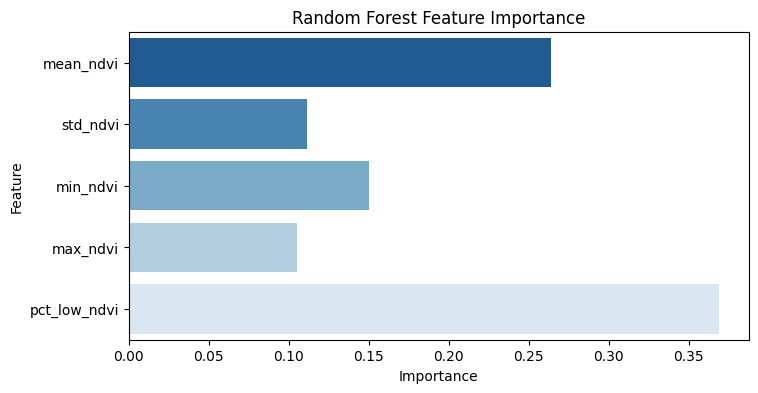

/var/folders/xd/w__5x95d37b_lkks4djd2m9h0000gp/T/ipykernel_8519/3067488392.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_importances.values, y=xgb_importances.index, palette='Reds_r')


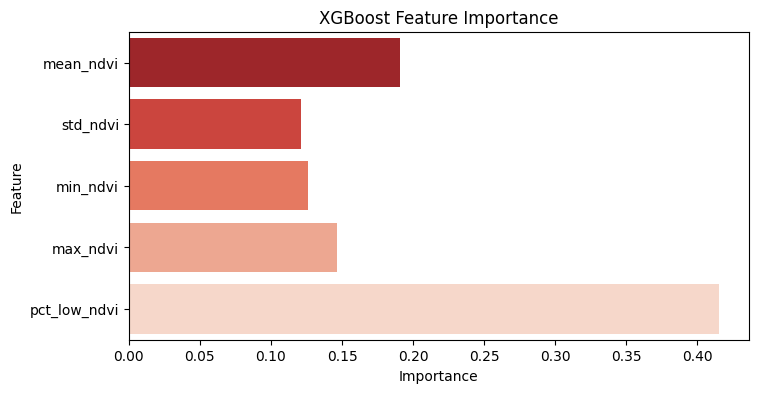

In [ ]:
# random forest feature importance
rf_importances = pd.Series(rf.feature_importances_, index=X.columns)

plt.figure(figsize=(8, 4))
sns.barplot(x=rf_importances.values, y=rf_importances.index, palette='Blues_r')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# xgboost feature importance
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)

plt.figure(figsize=(8, 4))
sns.barplot(x=xgb_importances.values, y=xgb_importances.index, palette='Reds_r')
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


We can see that low NDVI was the most important feature for both models, followed by mean NDVI. These results are consistent with our expectations: patches with large barren or paved surfaces (like vacant lots, roadways, parking lots) may be associated with higher violence risk, potentially due to lower availability of green space, increased sightline visibility, and/or neighborhood disinvestment.

### Deep Learning - Convolutional Neural Network (CNN)

A Convolutional Neural Network, or CNN, is a deep learning model designed to extract spatial features from image data. Unlike Random Forest and XGBoost, which use pre-calculated NDVI metrics, the CNN takes raw NDVI image patches as input and learns spatial patterns directly. The CNN performs the same core classification task as the machine learning models: predicting whether a 64×64 meter area corresponds to a firearm incident (label = 1) or a control location (label = 0). The model uses convolutional layers to detect patterns such as clustering or fragmentation of green space, as well as boundaries between green and non-green areas.

By extracting and combining these spatial features, the CNN can learn configurations of vegetation that are predictive of violence. The output of the CNN is a continuous probability between 0 and 1, representing the model's confidence that the patch is associated with a firearm incident. This approach allows for richer spatial interpretation and potentially higher predictive performance when spatial patterns are informative.


In [ ]:
class NDVIDataset(Dataset):
    def __init__(self, patches, labels):
        self.patches = patches
        self.labels = labels

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch = self.patches[idx]
        patch = np.nan_to_num(patch, nan=0.0)  # replace NaNs with 0
        patch = torch.tensor(patch, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return patch, label

# train-test split
from sklearn.model_selection import train_test_split

patches_train, patches_test, labels_train, labels_test = train_test_split(
    patches, labels, test_size=0.2, random_state=42, stratify=labels
)

train_dataset = NDVIDataset(patches_train, labels_train)
test_dataset = NDVIDataset(patches_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


#### Build CNN

In [75]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32 * 16 * 16, 64)  # For 64x64 patches
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [16, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))  # [32, 16, 16]
        x = x.view(-1, 32 * 16 * 16)
        x = self.dropout(F.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))  # Binary classification
        return x.squeeze()

model = CNN()

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model.to(device)


CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

#### Run CNN

Here, we run the CNN model on our training data. The model is trained for 20 epochs, and we can see that the loss decreases over time, indicating that the model is learning.

In [ ]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# training loop
for epoch in range(20):  # adjust number of epochs as needed
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")


Epoch 1, Loss: 0.5897786093480659
Epoch 2, Loss: 0.5363792912526564
Epoch 3, Loss: 0.4986327317627994
Epoch 4, Loss: 0.47982705768310663
Epoch 5, Loss: 0.440138939203638
Epoch 6, Loss: 0.40400030215581256
Epoch 7, Loss: 0.36512202588897763
Epoch 8, Loss: 0.3229846197998885
Epoch 9, Loss: 0.29880720828518725
Epoch 10, Loss: 0.2359474217801383
Epoch 11, Loss: 0.18921229435187398
Epoch 12, Loss: 0.15655242871831765
Epoch 13, Loss: 0.1200433388126619
Epoch 14, Loss: 0.10817110493327632
Epoch 15, Loss: 0.07028080830632737
Epoch 16, Loss: 0.06348650758578019
Epoch 17, Loss: 0.053980971319657386
Epoch 18, Loss: 0.044319513204479306
Epoch 19, Loss: 0.04057301665571603
Epoch 20, Loss: 0.034488563842111915


#### Calculate CNN AUC

In [ ]:
from sklearn.metrics import roc_auc_score

model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # move data to device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # forward pass
        outputs = model(inputs)
        
        # move outputs and labels back to CPU, convert to numpy
        all_probs.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

auc = roc_auc_score(all_labels, all_probs)
print(f"CNN AUC: {auc:.3f}")



CNN AUC: 0.880


Since the AUC for the CNN model is 0.88, this result suggests that the CNN outperforms the other two models. Let's take a look at the ROC and precision-recall curves to better visualize the models' performance.

## Model Comparison

### ROC curves
The following plot shows the ROC curves for all three models. The Random Forest and XGBoost models have similar AUC values, while the CNN model has a higher AUC value. This suggests that the CNN model is better at distinguishing between incident and control patches than the other two models.

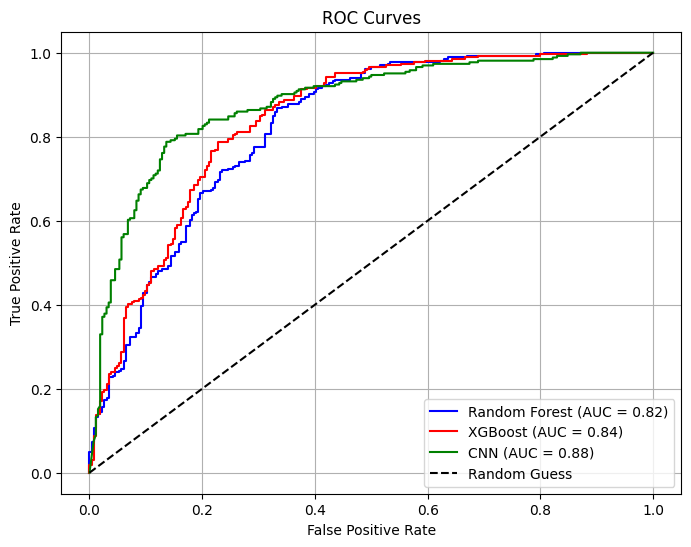

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# calculate ROC curves and AUCs for:
# random forest
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = auc(rf_fpr, rf_tpr)

# xgboost
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
xgb_auc = auc(xgb_fpr, xgb_tpr)

# CNN
cnn_fpr, cnn_tpr, _ = roc_curve(all_labels, all_probs)
cnn_auc = auc(cnn_fpr, cnn_tpr)

# plot all curves with AUC values
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})', color='blue')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})', color='red')
plt.plot(cnn_fpr, cnn_tpr, label=f'CNN (AUC = {cnn_auc:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Precision-recall curves
The following plot shows the precision-recall curves for all three models. The Random Forest and XGBoost models have similar precision-recall curves, while the CNN model has a higher precision-recall curve that optimizes precision and recall. This further suggests that the CNN model is better at predicting firearm incidents than the other two models.

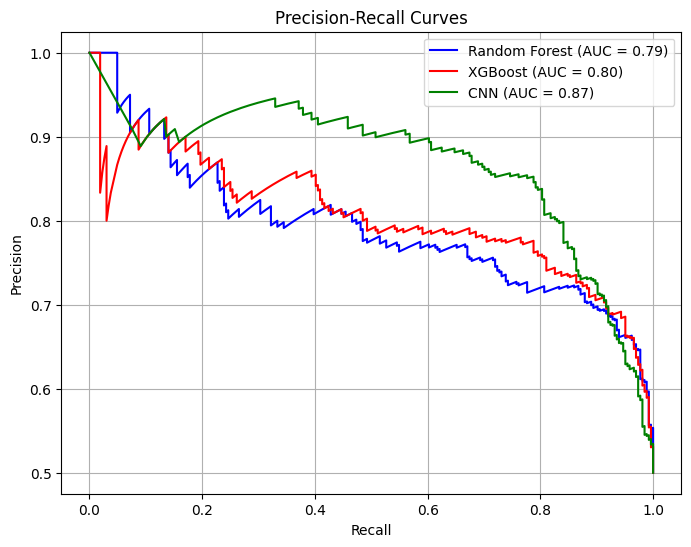

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# random forest
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
rf_pr_auc = auc(rf_recall, rf_precision)

# xgboost
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_probs)
xgb_pr_auc = auc(xgb_recall, xgb_precision)

# CNN
cnn_precision, cnn_recall, _ = precision_recall_curve(all_labels, all_probs)
cnn_pr_auc = auc(cnn_recall, cnn_precision)

# plot the precision-recall curves
plt.figure(figsize=(8, 6))
plt.plot(rf_recall, rf_precision, label=f'Random Forest (AUC = {rf_pr_auc:.2f})', color='blue')
plt.plot(xgb_recall, xgb_precision, label=f'XGBoost (AUC = {xgb_pr_auc:.2f})', color='red')
plt.plot(cnn_recall, cnn_precision, label=f'CNN (AUC = {cnn_pr_auc:.2f})', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


## Risk Prediction Map
The following map shows the predicted risk of firearm incidents across Philadelphia, based on the CNN model. The darker red areas represent high-risk areas as predicted by the model, while the lighter areas represent low-risk areas. This map should be considered an exploratory map showing the distribution of risk solely based on NDVI values and not any other important predictors of violence. Therefore, despite the CNN's high performance, we cannot recommend that this map be used to inform violence prevention efforts and urban planning initiatives without further development, validation, and community-based evaluation of the model.

In [102]:
patch_size = 64
stride = 16

# prepare prediction map in same shape as NDVI
pred_map = np.full(ndvi_masked.shape, np.nan)

# slide window across NDVI raster
for row in range(0, ndvi_masked.shape[0] - patch_size, stride):
    for col in range(0, ndvi_masked.shape[1] - patch_size, stride):
        patch = ndvi_masked[row:row+patch_size, col:col+patch_size]

        # skip patches with too many NaNs (e.g., rivers or outside boundary)
        if np.isnan(patch).mean() > 0.2:
            continue

        # prepare patch for CNN
        patch_tensor = torch.tensor(np.nan_to_num(patch), dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        patch_tensor = patch_tensor.to(device)

        # CNN prediction
        with torch.no_grad():
            prob = model(patch_tensor).cpu().item()

        # assign prediction to center of patch
        center_row = row + patch_size // 2
        center_col = col + patch_size // 2
        pred_map[center_row, center_col] = prob



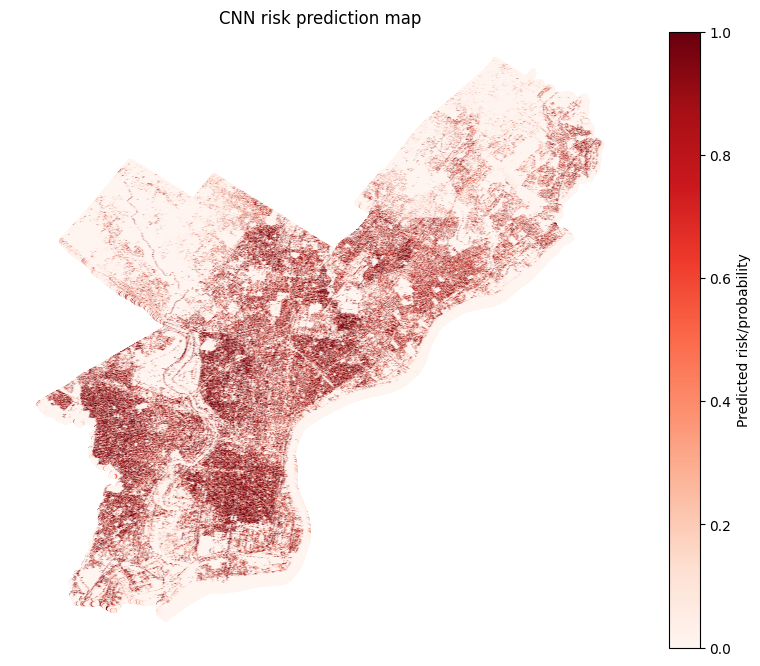

In [ ]:
rows, cols = np.where(~np.isnan(pred_map))
values = pred_map[rows, cols]

plt.figure(figsize=(10, 8))
plt.scatter(cols, rows, c=values, cmap='Reds', s=5, vmin=0, vmax=1)
plt.gca().invert_yaxis()  # match raster orientation
plt.colorbar(label='Predicted Risk/Probability')
plt.title('CNN Risk Prediction Map')
plt.axis('off')
plt.show()


## Discussion

This study demonstrates that NDVI from satellite imagery can serve as an effective predictor of firearm assault risk in urban environments. We found that lower NDVI values were consistently associated with a higher likelihood of firearm violence, supporting prior evidence that greener environments may have protective effects as shown by the pioneering work of Drs. Charles Branas and Douglas Wiebe (Branas et al. 2018).

However, it is critical to interpret NDVI not in isolation, but as a potential proxy for broader structural issues such as neighborhood disinvestment, systemic racism, and racial-economic segregation. Although this project focused primarily on environmental features, NDVI alone does not capture the complex, multilevel determinants of firearm violence. Without incorporating sociodemographic and built environment covariates, the risk of confounding and reverse causality remains high. Thus, NDVI should be considered one of many factors contributing to spatial risk, and future research should explore how greenness interacts with social vulnerability indicators to better target prevention efforts.

Methodologically, the project offers several innovations over traditional vector-based geographic analyses. Rather than aggregating observations into census tracts or block groups, which introduces spatial bias and artificial boundaries, this study utilized raster-based modeling and high-resolution imagery to capture spatial relationships at the pixel level. This approach increases the spatial precision of predictions and aligns more naturally with environmental data sources. For instance, while studies like Ogletree et al. (2022) conducted regression analysis at the block group level, our CNN model can make predictions across continuous urban surfaces, allowing for greater flexibility and finer granularity.

Among the modeling approaches tested, the convolutional neural network (CNN) outperformed Random Forest and XGBoost in predictive accuracy. CNNs appear to be well-suited for this kind of spatial pattern detection, as they can account for textures, gradients, and localized features that summary statistics in tabular models cannot easily capture. These results suggest that deep learning models merit more consideration in public health applications where spatial image data are available.

### Limitations

That said, there were limitations to this exploratory design. The dataset did not include covariates such as socioeconomic status, the Area Deprivation Index, alcohol outlet density, or vacant property concentration. All of these may confound or mediate the relationship between greenness and violence. Additionally, because firearm incident locations and control points often occupied overlapping areas, there was potential for spatial signal contamination, which may have biased model performance toward the null. This limitation highlights the need for carefully constructed case-control sampling in future work that focuses more on prediction than on interpretability.

### Conclusion

Overall, this project demonstrates the promise of combining remote sensing, spatial epidemiology, and AI to better understand the urban determinants of violence. Once underlying relationships are well-established through statistical inference, deep learning models such as CNNs can help optimize prediction for real-world use in public health interventions and urban policy planning.


## References

Branas, C. C., Richmond, T. S., Culhane, D. P., & Wiebe, D. J. (2018). Urban Blight and Violence: A Randomized Natural Experiment of Philadelphia's Vacant Lot Greening Program. *PLOS ONE*, 13(11), e0207363.

Ogletree, S. W., Branas, C. C., & South, E. C. (2022). The Role of Green Space in Firearm Violence: A Systematic Review. *International Journal of Environmental Research and Public Health*, 19(1), 1-16.